## Data cleaning and sanity checks

In this file, missing patterns of datasets are checked, and treatment patterns are analyzed for sanity checks and preparation for further analysis.

### Package, globals and functions

In [ ]:
# uncomment this line to install packages if not already installed
# !pip install numpy, pandas, matplotlib, scikit-learn

In [ ]:
import re
import os
from typing import Optional, Tuple
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

In [2]:
folder = "./monthly_data"

In [107]:
# function to clean firm_id
def clean_firm_id(firm_id: str) -> str:
    """Cleans the firm_id by stripping spaces, removing trailing '00', and checking format."""
    firm_id = firm_id.strip()
    if firm_id.endswith('00'):
        firm_id = firm_id[:-2]

    # Check if the cleaned firm_id follows the format ABCD-12
    pattern = r'^[A-Z]{4}-\d{2}$'
    if not re.match(pattern, firm_id):
        raise ValueError(f"Invalid firm_id format: {firm_id}")
    return firm_id

def to_month_index(s: pd.Series) -> np.ndarray:
    # change date to month index
    p = s.dt.to_period('M').astype(int)
    return p.to_numpy(dtype=float).reshape(-1, 1)

# Function to fill missing sales within each firm
def gp_impute_firm_values(
        firm_sales_cleaned: pd.DataFrame,
        target_col: str = 'sales_t',
        group_col: str = 'firm_id',
    ) -> pd.DataFrame:
    """
    Use Gaussian Process to impute missing values within each group for target_col.
    """

    # check input dataframe has required columns
    required_cols = {group_col, 'date', target_col}
    missing_cols = required_cols - set(firm_sales_cleaned.columns)
    if missing_cols:
        raise KeyError(f"Missing required columns in input dataframe: {missing_cols}")

    df = firm_sales_cleaned.copy()

    # confirm on date column type
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].isna().any():
        bad = df.loc[df['date'].isna()].head()
        raise ValueError(f"Some dates could not be parsed. Example rows:\n{bad}")

    def impute_group(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values('date').copy()
        y = g[target_col]
        miss = y.isna()
        if not miss.any():
            return g

        X_all = to_month_index(g['date'])
        X_train = X_all[~miss.to_numpy()]
        X_pred = X_all[miss.to_numpy()]
        y_train = y.loc[~miss].to_numpy(dtype=float)

        if y_train.size < 2:
            # use linear interpolation if too few points to fit GP
            print("Linear interpolation used due to insufficient data points.")
            g[target_col] = y.interpolate(method='linear', limit_direction='both')
            return g
    

        kernel = (
            C(1.0, (1e-6, 1e6))
            * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e6))
            + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-9, 1e1))
        )
        gp = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            n_restarts_optimizer=3,
            random_state=42,
            alpha=1e-6
        )

        # warnings.filterwarnings("ignore", category=ConvergenceWarning)

        try:
            gp.fit(X_train, y_train)
            y_pred = gp.predict(X_pred)
            g.loc[miss, target_col] = y_pred
        except Exception:
            # backup plan: linear interpolation if GP fails
            print("GP fitting failed, using linear interpolation instead.")
            g[target_col] = y.interpolate(method='linear', limit_direction='both')

        # backup plan: ensure no remaining missing values
        if g[target_col].isna().any():
            print("Remaining missing values after GP, using linear interpolation.")
            g[target_col] = g[target_col].interpolate(method='linear', limit_direction='both')

        return g

    non_group_cols = [c for c in firm_sales_cleaned.columns if c != group_col]
    out = (
        df.groupby(group_col, sort=False)[non_group_cols]
          .apply(impute_group)
          .reset_index()
    )
    out.drop(columns='level_1', inplace=True, errors='ignore')
    return out

def first_adoption_row(g: pd.DataFrame) -> pd.DataFrame:
    '''
    Get the first row where the firm adopted the program.
    '''
    g = g.sort_values('date').copy()
    adopt = g['adopt_t'].fillna(0).astype(int)
    prev = adopt.shift(fill_value=0)
    trans = (adopt == 1) & (prev == 0)
    return g.loc[trans].head(1)

def has_dropout(g: pd.DataFrame) -> pd.Series:
    '''
    Check if a firm has dropped out after adopting the program.
    '''
    g = g.sort_values('date')
    adopt = g['adopt_t'].fillna(0).astype(int)
    had_adopted = adopt.cummax()
    dropped = ((had_adopted == 1) & (adopt == 0)).any()
    return pd.Series({'dropped_out': bool(dropped)})


### Data Cleaning & Wrangling

#### Firm Information

In [5]:
# Check for missing data in the firm_info dataframe
firm_info = pd.read_csv('firm_information.csv')
missing_data = firm_info.isnull().sum()
print("Missing data in each column:")
print(missing_data)
firm_info.describe()

# firm_id and firm_name have no missing values and are unique, so we can use them as identifiers

Missing data in each column:
firm_id        0
firm_name      0
firm_sector    0
dtype: int64


,firm_id,firm_name,firm_sector
count,498,498,498
unique,498,498,3
top,AAAI-15,Resorts International Holdings,Retail
freq,1,1,209


Distribution of firm_sector:
firm_sector
Retail         209
Hospitality    149
Fast Food      140
Name: count, dtype: int64


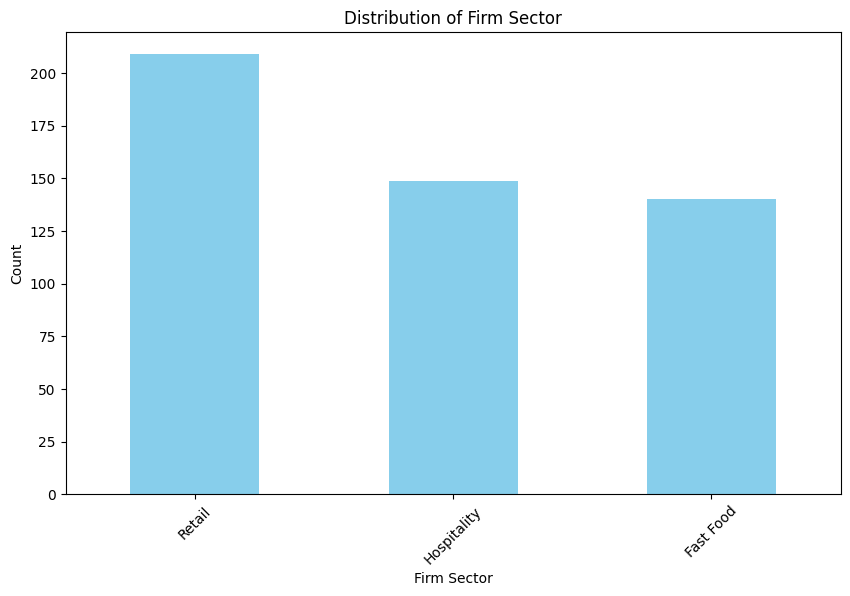

In [6]:
# Check the distribution of the 'firm_sector' column
if 'firm_sector' in firm_info.columns:
    sector_distribution = firm_info['firm_sector'].value_counts()
    print("Distribution of firm_sector:")
    print(sector_distribution)
    plt.figure(figsize=(10, 6))
    sector_distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Firm Sector')
    plt.xlabel('Firm Sector')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


#### Aggregate firm sales

In [13]:
# Check for wrongly represented firm_id in the firm_sales dataframe

# firm id in firm_sales and firm_aux include spaces which need to be stripped, and extra two zeros at the end of firm_id need to be removed
firm_sales = pd.read_csv('aggregate_firm_sales.csv')
firm_sales['firm_id'] = firm_sales['firm_id'].apply(clean_firm_id)
firm_sales = firm_sales.merge(firm_info[['firm_id', 'firm_sector']], on='firm_id', how='left')
missing_data = firm_sales.isnull().sum()
print("Missing data in each column:")
print(missing_data)
firm_sales.describe()

# All firm sector cleaned!
# sales has no negative or extra large values, so we only need to deal with missing values

Missing data in each column:
firm_id           0
date              0
sales_t        2100
firm_sector       0
dtype: int64


,sales_t
count,54546.000000
mean,8633.203241
std,5276.016213
min,504.000000
25%,4266.000000
50%,7978.000000
75%,12003.000000
max,45973.000000


In [59]:
firm_sales_cleaned = firm_sales.copy()
firm_sales_cleaned['date'] = pd.to_datetime(firm_sales_cleaned['date'], errors='coerce')
firm_sales_cleaned['date'] = firm_sales_cleaned['date'].dt.to_period("M").dt.to_timestamp()

In [60]:
# Fill in missing values of firm's sales within each firm_sector using Gaussian Process

# Apply the function to firm_sales
firm_with_filled_sales = gp_impute_firm_values(firm_sales_cleaned, target_col='sales_t', group_col='firm_id')

In [61]:
# save the imputed dataset to a new csv
firm_with_filled_sales.to_csv('aggregate_firm_sales_filled.csv', index=False)
firm_sales_cleaned.to_csv('aggregate_firm_sales_cleaned.csv', index=False)


#### Auxiliary firm data

In [62]:
# Check for first month of data after applying the same cleaning and merging process
first = pd.read_csv('./monthly_data/2010_1.csv')
first['firm_id'] = first['firm_id'].apply(clean_firm_id)
first = first.merge(firm_info[['firm_id', 'firm_sector']], on='firm_id', how='left')
missing_data = first.isnull().sum()
print("Missing data in each column:")
print(missing_data)
first.describe()

Missing data in each column:
date             0
firm_id          0
employment_t    17
wage_bill_t     20
revenue_t       15
adopt_t          0
firm_sector      0
dtype: int64


,employment_t,wage_bill_t,revenue_t,adopt_t
count,455.000000,452.000000,4.570000e+02,472.0
mean,96.336264,28741.805841,6.044910e+05,0.0
std,39.100502,14981.103128,5.094930e+05,0.0
min,24.000000,4402.840000,1.777419e+04,0.0
25%,64.000000,15951.960000,1.745283e+05,0.0
50%,96.000000,28085.800000,4.757357e+05,0.0
75%,127.500000,40533.900000,8.685781e+05,0.0
max,177.000000,72985.680000,2.522237e+06,0.0


In [63]:
# fixing date issue in auxiliary data and cleaning firm_id
p = Path(folder)
frames = []
for csv_path in sorted(p.glob("*.csv")):
    m = re.match(r"^(?P<y>\d{4})_(?P<m>\d{1,2})$", csv_path.stem)
    if not m:
        print(f"Jump file unavailable: {csv_path.name}")
        continue

    y = int(m.group("y"))
    mth = int(m.group("m"))
    date_val = pd.Timestamp(year=y, month=mth, day=1)

    df_i = pd.read_csv(csv_path)
    df_i = df_i.drop(columns=["date"], errors="ignore")
    df_i["date"] = date_val

    df_i['firm_id'] = df_i['firm_id'].apply(clean_firm_id)

    frames.append(df_i)

middle = pd.concat(frames, ignore_index=True)
middle.to_csv('aggregate_firm_aux_cleaned.csv', index=False)
# middle also has 56646 observations, same as entries in firm_sales!

In [ ]:
# Fill in missing employment, wage bill and revenue
detrend_cols = ['employment_t', 'wage_bill_t', 'revenue_t']
for col in detrend_cols:
    middle_filled = gp_impute_firm_values(middle, target_col=col, group_col='firm_id')
    middle = middle_filled
    print(f"Filled missing values for {col}")
middle.to_csv('aggregate_firm_aux_filled.csv', index=False)


Filled missing values for employment_t
Filled missing values for wage_bill_t
Filled missing values for revenue_t


#### Final aggregation

In [121]:
# Since both dataframe has the same number of observations, we could merge them directly
firm_sales_final = pd.read_csv('aggregate_firm_sales_cleaned.csv')
firm_aux_final = pd.read_csv('aggregate_firm_aux_cleaned.csv')
final = firm_sales_final.merge(firm_aux_final, on=['firm_id', 'date'], how='left')
final.to_csv('aggregate_firm_final_cleaned.csv', index=False)

In [122]:
firm_sales_final_filled = pd.read_csv('aggregate_firm_sales_filled.csv')
firm_aux_final_filled = pd.read_csv('aggregate_firm_aux_filled.csv')
final_filled = firm_sales_final_filled.merge(firm_aux_final_filled, on=['firm_id', 'date'], how='left')
final_filled.to_csv('aggregate_firm_final_filled.csv', index=False)

### Eligibility check and data Description

#### Program eligibility check

In [ ]:
# check that firms all adopt the program on 2013-01-01 and won't opt out
first_adopt = (
    final
    .dropna(subset=['firm_id', 'date'])
    .groupby('firm_id', group_keys=False, sort=False)
    .apply(first_adoption_row)
    .reset_index(drop=True)
)

dropout_flag = (
    final
    .dropna(subset=['firm_id', 'date'])
    .groupby('firm_id', as_index=False, sort=False)
    .apply(has_dropout)
    .reset_index(drop=True)
)
# Find that not all firms adopted the program on 2013-01-01

/var/folders/8k/bf2_91gd1j75mgs4pgp5x3n80000gn/T/ipykernel_1811/2552059611.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(first_adoption_row)
/var/folders/8k/bf2_91gd1j75mgs4pgp5x3n80000gn/T/ipykernel_1811/2552059611.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(has_dropout)


In [111]:
adopt_distribution = first_adopt['date'].value_counts()
num_firms = dropout_flag.shape[0]
num_dropped = int(dropout_flag['dropped_out'].sum())
print(f'Distribution of adoption year: {adopt_distribution}')
print(f'Total number of firms: {num_firms}')
print(f'Number and share of firms dropping out: {num_dropped} ({num_dropped/num_firms:.2%})')

Distribution of adoption year: date
2013-01-01    174
2018-07-01      2
2013-11-01      1
2016-07-01      1
2018-06-01      1
2015-02-01      1
2016-01-01      1
Name: count, dtype: int64
Total number of firms: 498
Number and share of firms dropping out: 0 (0.00%)


In [115]:
# check that firms all adopt the program on 2013-01-01 and won't opt out
first_adopt_filled = (
    final_filled
    .dropna(subset=['firm_id', 'date'])
    .groupby('firm_id', group_keys=False, sort=False)
    .apply(first_adoption_row)
    .reset_index(drop=True)
)

dropout_flag_filled = (
    final_filled
    .dropna(subset=['firm_id', 'date'])
    .groupby('firm_id', as_index=False, sort=False)
    .apply(has_dropout)
    .reset_index(drop=True)
)
# Find that not all firms adopted the program on 2013-01-01

/var/folders/8k/bf2_91gd1j75mgs4pgp5x3n80000gn/T/ipykernel_1811/3487072785.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(first_adoption_row)
/var/folders/8k/bf2_91gd1j75mgs4pgp5x3n80000gn/T/ipykernel_1811/3487072785.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(has_dropout)


In [116]:
adopt_distribution_filled = first_adopt_filled['date'].value_counts()
num_firms_filled = dropout_flag_filled.shape[0]
num_dropped_filled = int(dropout_flag_filled['dropped_out'].sum())
print(f'Distribution of adoption year: {adopt_distribution_filled}')
print(f'Total number of firms: {num_firms_filled}')
print(f'Number and share of firms dropping out: {num_dropped_filled} ({num_dropped_filled/num_firms_filled:.2%})')

Distribution of adoption year: date
2013-01-01    174
2018-07-01      2
2013-11-01      1
2016-07-01      1
2018-06-01      1
2015-02-01      1
2016-01-01      1
Name: count, dtype: int64
Total number of firms: 498
Number and share of firms dropping out: 0 (0.00%)


#### Qualitative data analysis

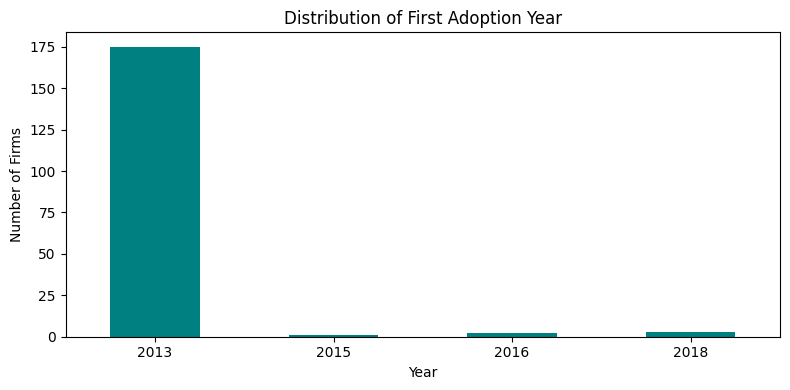

In [123]:
# visualize year that firms adopt the program
first_adopt = first_adopt.copy()
first_adopt['adopt_year'] = pd.to_datetime(first_adopt['date']).dt.year
year_counts = first_adopt['adopt_year'].value_counts().sort_index()

plt.figure(figsize=(8,4))
year_counts.plot(kind='bar', color='teal')
plt.title('Distribution of First Adoption Year')
plt.xlabel('Year')
plt.ylabel('Number of Firms')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# After imputation this remains the same as adoption year is not missing

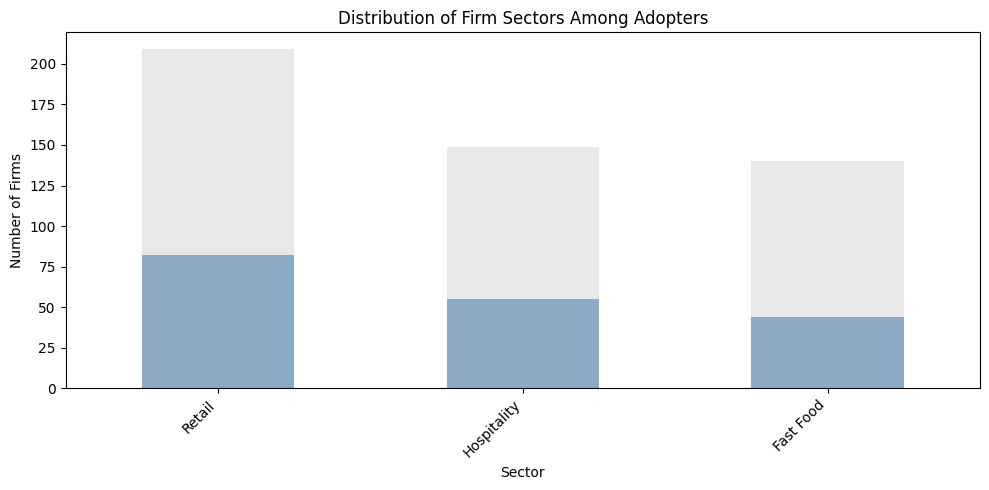

In [ ]:
# visualize the distribution of firm sectors among adopters
sector_counts = first_adopt['firm_sector'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sector_counts.plot(kind='bar', color='steelblue')
firm_info['firm_sector'].value_counts().plot(kind='bar', color='lightgray', alpha=0.5)
plt.title('Distribution of Firm Sectors Among Adopting Firms')
plt.xlabel('Sector')
plt.ylabel('Number of Firms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# After imputation this remains the same as firm sector is not missing

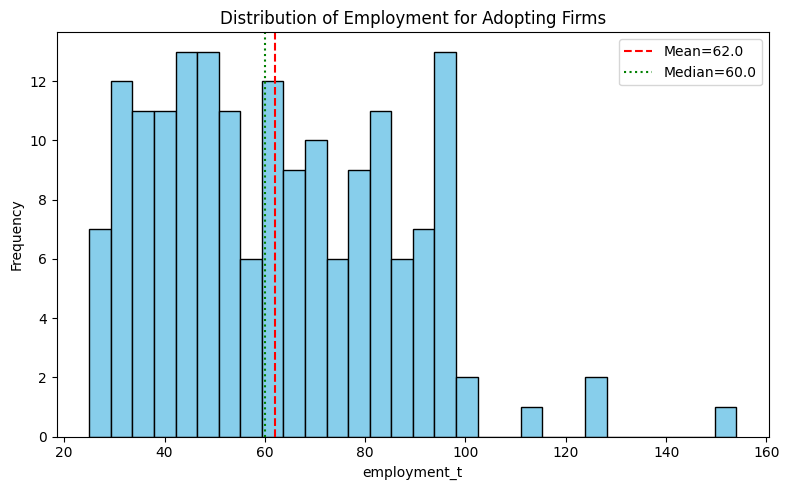

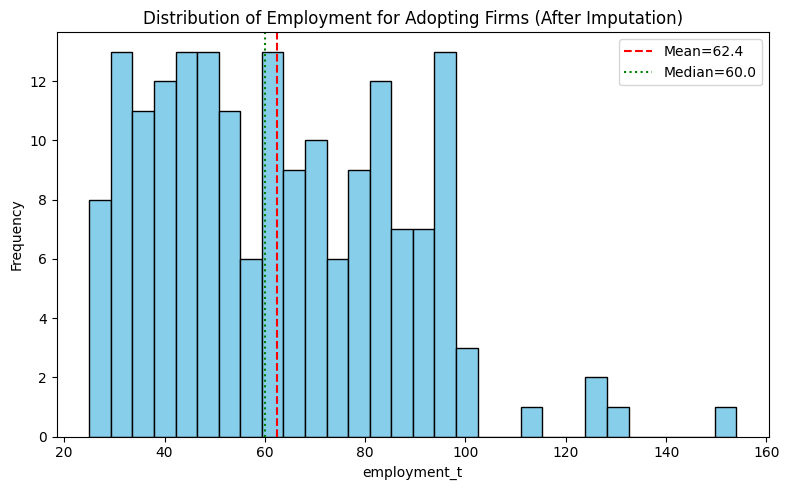

In [124]:
# visualize the distribution of employees among adopters
emp_vals = pd.to_numeric(first_adopt['employment_t'], errors='coerce').dropna()
plt.figure(figsize=(8,5))
plt.hist(emp_vals, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Employment for Adopting Firms')
plt.xlabel('employment_t')
plt.ylabel('Frequency')
# Reference lines: Mean and Median
mean_v, med_v = emp_vals.mean(), emp_vals.median()
plt.axvline(mean_v, color='red', linestyle='--', label=f'Mean={mean_v:.1f}')
plt.axvline(med_v, color='green', linestyle=':', label=f'Median={med_v:.1f}')
plt.legend()
plt.tight_layout()
plt.show()

# visualize the distribution of employees among adopters after imputation
emp_vals_filled = pd.to_numeric(first_adopt_filled['employment_t'], errors='coerce').dropna()
plt.figure(figsize=(8,5))
plt.hist(emp_vals_filled, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Employment for Adopting Firms (After Imputation)')
plt.xlabel('employment_t')
plt.ylabel('Frequency')
# Reference lines: Mean and Median
mean_v_filled, med_v_filled = emp_vals_filled.mean(), emp_vals_filled.median()
plt.axvline(mean_v_filled, color='red', linestyle='--', label=f'Mean={mean_v_filled:.1f}')
plt.axvline(med_v_filled, color='green', linestyle=':', label=f'Median={med_v_filled:.1f}')
plt.legend()
plt.tight_layout()
plt.show()

### Final Adjustment

Since we know from the setting that:   
- The program began on January 1st, 2013.   
- Only firms with 100 or fewer employees were eligible to participate in the program.   
We drop abnormal observations since they don't follow these domain knowledge

In [125]:
# For original data, we drop firms that didn't adopt on 2013-01-01 or have more than 100 employees
fa = first_adopt.copy()
fa['date'] = pd.to_datetime(fa['date'], errors='coerce')
fa['employment_t_num'] = pd.to_numeric(fa['employment_t'], errors='coerce')

bad_mask = (fa['date'] != pd.Timestamp('2013-01-01')) | (fa['employment_t_num'] > 100)
bad_firms = fa.loc[bad_mask, 'firm_id'].dropna().unique()

print(f'Number of firms to drop: {len(bad_firms)}')

# Drop the firms
before_n = final['firm_id'].nunique()
final = final[~final['firm_id'].isin(bad_firms)].copy()
after_n = final['firm_id'].nunique()

print(f'Number of firms: Before dropping {before_n}, After dropping {after_n}, Reduced {before_n - after_n}')

Number of firms to drop: 11
Number of firms: Before dropping 498, After dropping 487, Reduced 11


In [126]:
# For imputed data, we drop firms that didn't adopt on 2013-01-01 or have more than 100 employees
fa_filled = first_adopt_filled.copy()
fa_filled['date'] = pd.to_datetime(fa_filled['date'], errors='coerce')
fa_filled['employment_t_num'] = pd.to_numeric(fa_filled['employment_t'], errors='coerce')

bad_mask_filled = (fa_filled['date'] != pd.Timestamp('2013-01-01')) | (fa_filled['employment_t_num'] > 100)
bad_firms_filled = fa_filled.loc[bad_mask_filled, 'firm_id'].dropna().unique()

print(f'Number of firms to drop: {len(bad_firms_filled)}')

# Drop the firms
before_n = final_filled['firm_id'].nunique()
final_filled = final_filled[~final_filled['firm_id'].isin(bad_firms_filled)].copy()
after_n = final_filled['firm_id'].nunique()

print(f'Number of firms: Before dropping {before_n}, After dropping {after_n}, Reduced {before_n - after_n}')

Number of firms to drop: 13
Number of firms: Before dropping 498, After dropping 485, Reduced 13


In [127]:
final.to_csv('aggregate_firm_final_cleaned.csv', index=False)
final_filled.to_csv('aggregate_firm_final_filled.csv', index=False)